In [873]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import TimestampType
import pytrends
from pytrends.request import TrendReq
import gzip
import matplotlib.pyplot as plt
import matplotlib
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
import urllib.request
from PIL import Image
from IPython.display import display
import pytesseract
from pytesseract import image_to_boxes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

path='/Users/coralineduval/Downloads/BA report/'

# For Amazon data

In [465]:
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as f:
        for l in f:
            d = json.loads(l.strip())
            count += 1
            data.append(d)
            
            # break if reaches the 'head' line
            if (head is not None) and (count > head):
                break
    return data

# load the data
# goodreads_books = load_data(path+'goodreads_books.json.gz',100000)

# # convert list into pandas dataframe
# df_g = pd.DataFrame.from_dict(goodreads_books)

# print(len(df_g))
# print(df_g.columns)
# print(df_g.loc[2])

##other way to read json
#pd.read_json('file.jl.gz', lines=True, compression='gzip)



In [466]:
### load the data
books = load_data(path+'Books.json.gz',1000)

# convert list into pandas dataframe
df = pd.DataFrame.from_dict(books)

print(len(df))
print(df.columns)
print(df.loc[2])

### remove rows with unformatted title (i.e. some 'title' may still contain html style content)
#df3 = df.fillna('')
#df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
#df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
#print(len(df4))
#print(len(df5))

# how those unformatted rows look like
#df4.iloc[0]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/coralineduval/Downloads/BA report/Books.json.gz'

In [468]:
### load the meta data
books_meta = load_data(path+'meta_Books.json.gz',1000)

# convert list into pandas dataframe
df_m = pd.DataFrame.from_dict(books_meta)

print(len(df_m))
print(df_m.columns)
print(df_m.loc[2])

### remove rows with unformatted title (i.e. some 'title' may still contain html style content)
# df3_m = df_m.fillna('')
# df4_m = df3_m[df3_m.title.str.contains('getTime')] # unformatted rows
# df5_m = df3_m[~df3_m.title.str.contains('getTime')] # filter those unformatted rows
# print(len(df4_m))
# print(len(df5_m))

print(len(df_m[df_m.imageURLHighRes.str.len() > 0])) #no data with picture links


1001
Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes'],
      dtype='object')
category                          [Books, Arts & Photography, Music]
tech1                                                               
description        [Discography of American Punk, Hardcore, and P...
fit                                                                 
title              Flex! Discography of North American Punk, Hard...
also_buy                                                          []
tech2                                                               
brand                                               Burkhard Jarisch
feature                                                           []
rank                                            6,291,012 in Books (
also_view                                                      

In [ ]:
amazon_rank=pd.read_csv(path + 'amazon_com.csv')
amazon_rank.merge(df_m, left_on='ASIN', right_on='asin')

One result only when joining the amazon books data and amazon ranking of books on their ASIN

# For Goodreads data

## Loading data

In [ ]:
sc = SparkSession.builder.master('local[*]').config("spark.driver.memory", "15g").getOrCreate()
sqlContext = SQLContext(sc)

book_genres=pd.read_json(path+'goodreads_book_genres_initial.json.gz',lines = True)
book_genres=pd.concat([book_genres,pd.json_normalize(book_genres.genres)], axis=1)
book_genres=book_genres.drop(columns=['genres'])

book_works = sc.read.json(path+'goodreads_book_works.json.gz')
book_works=book_works.rdd

books = sc.read.json(path+'goodreads_books.json.gz')
books=books.rdd


## Display of data first rows

In [ ]:
book_genres.head()

   book_id  history, historical fiction, biography  fiction  \
0  5333265                                     1.0      NaN   
1  1333909                                     5.0    219.0   
2  7327624                                     NaN      8.0   
3  6066819                                     NaN    555.0   
4   287140                                     NaN      NaN   

   fantasy, paranormal  mystery, thriller, crime  poetry  romance  \
0                  NaN                       NaN     NaN      NaN   
1                  NaN                       NaN     NaN      NaN   
2                 31.0                       1.0     1.0      NaN   
3                  NaN                      10.0     NaN     23.0   
4                  NaN                       NaN     NaN      NaN   

   non-fiction  children  young-adult  comics, graphic  
0          NaN       NaN          NaN              NaN  
1          NaN       NaN          NaN              NaN  
2          NaN       NaN          N

In [ ]:
print(sqlContext.createDataFrame(book_works).show(1))
print(sqlContext.createDataFrame(books).show(1))

+------------+-----------+--------------------------+---------------------------------+----------+--------------------+------------------------+--------------------------+-------------------------+--------------------+--------------------+-------------+-----------+-------------+------------------+-------+
|best_book_id|books_count|default_chaptering_book_id|default_description_language_code|media_type|original_language_id|original_publication_day|original_publication_month|original_publication_year|      original_title|         rating_dist|ratings_count|ratings_sum|reviews_count|text_reviews_count|work_id|
+------------+-----------+--------------------------+---------------------------------+----------+--------------------+------------------------+--------------------------+-------------------------+--------------------+--------------------+-------------+-----------+-------------+------------------+-------+
|     5333265|          1|                          |                          

## Count of rows (long execution)

In [ ]:
%%time
books.count()
#2 360 655

2360655

In [ ]:
%%time
print(len(book_genres)) #23 606 655
print(book_works.count()) #1 521 962

2360655
1521962
CPU times: user 7.33 ms, sys: 4.66 ms, total: 12 ms
Wall time: 18.1 s


## Attempts at joining book data and book 'sale'

In [ ]:
books_f=books.filter(lambda l : (l[0]!='' and l[19]>'2010' and l[13] in ('en-US', 'eng', 'en-GB', 'en-CA', 'en') and l[21]>'5')).map(lambda l: (l[0],l[25]))
print(sqlContext.createDataFrame(books_f).show(11))

In [ ]:
books.filter(lambda l : (l[0]=='')).count()
# 1 891 138 / 2 360 655 : 80% so only 20% have asin number, not much to make a join

1891138

In [ ]:
#joining on asin
amazon_rank=pd.read_csv(path+'amazon_com.csv')
amazon_rank=sqlContext.createDataFrame(amazon_rank).rdd
print(sqlContext.createDataFrame(amazon_rank).show(10))

books_fa=amazon_rank.map(lambda l : (l[0],l[1])).join(books_f).map(lambda l : (l[0],l[1][0],l[1][1]))
print(sqlContext.createDataFrame(books_fa).show(11))
print(books_fa.count()) 

+----------+-----+---------+
|      ASIN|GROUP|   FORMAT|
+----------+-----+---------+
|0307463745| book|hardcover|
|0061914177| book|hardcover|
|1606840606| book|hardcover|
|0979974623| book|hardcover|
|0375829652| book|hardcover|
|0375840648| book|hardcover|
|0061583251| book|hardcover|
|0226532623| book|hardcover|
|0061766089| book|hardcover|
|0345507894| book|hardcover|
+----------+-----+---------+
only showing top 10 rows

None
+----------+------+--------------------+
|        _1|    _2|                  _3|
+----------+------+--------------------+
|B017RBIZII|kindle|The Last Woman St...|
|B00L1AJUKE|kindle| Mayhem (Mayhem, #1)|
|B005WIRO6I|kindle|Two Old Fools - O...|
|B002E9IPSO|kindle|       Blackbird Fly|
|B008UZIMDE|kindle|Time Between Us (...|
|B073RRSXB6|kindle|The Girl Who Came...|
|B007Q6P8WG|kindle|            The Cage|
|B071H7F5LG|kindle|         Two Sisters|
|B01N4TJ3N3|kindle|Follow Me Back (F...|
|B01MYWXUB7|kindle|The Beachside Swe...|
|B01N9JCRD4|kindle|Wicked in H

not enough results from merge to be usable, trying next to merge on the book titles

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType
amazon_rank_title=pd.read_csv(path+'amazon_com_extras.csv',error_bad_lines=False)
schema = StructType([StructField("ASIN", StringType(), True),\
                    StructField("GROUP", StringType(), True),\
                    StructField("FORMAT", StringType(), True),\
                    StructField("TITLE", StringType(), True),\
                    StructField("AUTHOR", StringType(), True),\
                    StructField("PUBLISHER", StringType(), True)])
amazon_rank_title=sqlContext.createDataFrame(amazon_rank_title, schema=schema).rdd
books_f=books.filter(lambda l : (l[0]!='' and l[19]>'2010' and l[13] in ('en-US', 'eng', 'en-GB', 'en-CA', 'en') and l[21]>'5')).map(lambda l: (l[25],l[20]))
books_fa=amazon_rank_title.map(lambda l : (l[3],l[4],l[5])).join(books_f)
print(sqlContext.createDataFrame(books_fa).show(11))
print(books_fa.count())

b'Skipping line 1693: expected 6 fields, saw 8\nSkipping line 2391: expected 6 fields, saw 7\nSkipping line 2486: expected 6 fields, saw 15\nSkipping line 3021: expected 6 fields, saw 7\nSkipping line 5025: expected 6 fields, saw 7\nSkipping line 7090: expected 6 fields, saw 8\nSkipping line 7386: expected 6 fields, saw 7\nSkipping line 7841: expected 6 fields, saw 10\nSkipping line 8601: expected 6 fields, saw 8\nSkipping line 8611: expected 6 fields, saw 8\nSkipping line 9464: expected 6 fields, saw 7\nSkipping line 10464: expected 6 fields, saw 8\nSkipping line 12675: expected 6 fields, saw 7\nSkipping line 13081: expected 6 fields, saw 7\nSkipping line 14941: expected 6 fields, saw 8\nSkipping line 16632: expected 6 fields, saw 7\nSkipping line 17124: expected 6 fields, saw 9\nSkipping line 17238: expected 6 fields, saw 7\nSkipping line 17480: expected 6 fields, saw 9\nSkipping line 17683: expected 6 fields, saw 8\nSkipping line 17685: expected 6 fields, saw 7\nSkipping line 17903:

+--------------------+--------------------+
|                  _1|                  _2|
+--------------------+--------------------+
|               Fever|{Lauren DeStefano...|
|               Fever|{Lauren DeStefano...|
|Hotel Scarface: W...|{Roben Farzad, Be...|
|        Come Sundown|{Nora Roberts, Br...|
|        Come Sundown|{Nora Roberts, Br...|
|              Olivia|{Ian Falconer, Re...|
|              Olivia|{Ian Falconer, Am...|
|           Dark Star|{Gautam Chintaman...|
|It's Not Me, It's...|{Stephanie Kate S...|
|         Wolf Hollow|{Lauren Wolk, RHC...|
|               Chomp|{Carl Hiaasen, Kn...|
+--------------------+--------------------+
only showing top 11 rows

None
1478


a bit better but still not enough results, let's use another way to get 'sales'

## Preprocessing the goodreads data

I am selecting books published in or after 2010 (a time when people had started buying and looking for books online regularly), where i will have google trend data to match it, books that are written in english so i can use text analysis on titles and texts and also selecting books that have a minimum of 5 reviews (which is a minimum sample i have chosen)

In [ ]:
books_f=books.filter(lambda l : (l[19]>='2010' and l[13] in ('en-US', 'eng', 'en-GB', 'en-CA', 'en') and l[21]>'5')).map(lambda l: (l[28],(l[3],l[17],l[18],l[19])))
#print(books_f.count())
b_w=book_works.map(lambda l: (l[15],(l[6],l[7],l[8])))
books_fe=b_w.join(books_f)
books_fe=books_fe.map(lambda x: (x[0],x[1][1][0],x[1][0][0],x[1][0][1],x[1][0][2],x[1][1][1],x[1][1][2],x[1][1][3])).filter(lambda x: (x[2]==x[5] and x[3]==x[6] and x[4]==x[7] ))
print(sqlContext.createDataFrame(books_fe).show(11))
books_id=books_fe.map(lambda l: l[1]).collect()
print(len(books_id))

+--------+--------+---+---+----+---+---+----+
|      _1|      _2| _3| _4|  _5| _6| _7|  _8|
+--------+--------+---+---+----+---+---+----+
|41823434|22399997| 24|  3|2016| 24|  3|2016|
|50078656|29736099| 30|  5|2017| 30|  5|2017|
|24258097|18488993| 12|  9|2013| 12|  9|2013|
|42665148|23115590| 17|  8|2014| 17|  8|2014|
|48654624|30136927| 10| 10|2016| 10| 10|2016|
|43082585|23492308|  1|  9|2015|  1|  9|2015|
|43082585|31352930|  1|  9|2015|  1|  9|2015|
|43082585|26876434|  1|  9|2015|  1|  9|2015|
|41470919|10410278|  1|  9|2011|  1|  9|2011|
|26493496|18667833| 29|  4|2014| 29|  4|2014|
|20221147|14578407|   |  6|2012|   |  6|2012|
+--------+--------+---+---+----+---+---+----+
only showing top 11 rows

None
50744


I also want to exclude certain types of books as they are not quite in the same category : books which have no category, poetry, non-fiction, comics, graphic and history, children, historical fiction, biography (while it includes historical fiction, it also has 2 non fictions categories : historical and biography).
As these genres are user defined, i decided to consider that a book is a certain gender by the max it gets of all the gender categories

In [ ]:
# getting all other type of data through selecting only those from books_id
b_genres=book_genres[book_genres.book_id.isin([int(i) for i in books_id])]
b_genres=b_genres.set_index('book_id')
b_genres.loc[:,'max_genre']=b_genres.idxmax(axis=1,skipna=True)
b_genres=b_genres[b_genres.max_genre.isin(['fiction','fantasy, paranormal','mystery, thriller, crime','romance','young-adult'])].copy()
books_id=list(b_genres.index)
print(len(books_id))

35471


Finally we select in all out dataframes the resulting book index and corresponding authors and series and transform them to spark dataframes (easier to manipulate and visulalise than RDD and still able to handle the size of the data (while pandas can't))

In [ ]:
b=books.filter(lambda l: int(l[3]) in books_id)
book_df=b.toDF()

## Loading the google trend data on the titles

In [ ]:
#for titles below 20 characters, we leave them as is, considering somebody would type it in full if looking for it, however we split on brackets when there is a # that indicate serie number
titles_1=book_df.filter(length(col("title_without_series")) <=20).select('title_without_series').collect()
l1 = book_df.filter(length(col("title_without_series")) <=20).select('title_without_series','book_id').collect()
t1=[{value['title_without_series'].split('(')[0].strip():value['book_id']}  if '(' in value['title_without_series'] and '#' in value['title_without_series'] else {value['title_without_series']:value['book_id']} for value in l1]

l2 = book_df.filter(length(col("title_without_series")) >20).select('title_without_series','book_id')
split_col = split(l2.title_without_series, '[-():;.]') #only keeping the first part of titles so that google trend find more results, finds results on exact match of word so should not be too specific
l2 = l2.withColumn('formatted_title', split_col.getItem(0))
titles_2=l2.select('formatted_title','book_id').collect()
t2=[{value['formatted_title'].strip():value['book_id']} for value in titles_2]

titles=t1+t2

In [ ]:
#exporting titles to execute it in a separate file
import json
with open('titles_book_id', 'w') as fout:
    json.dump(titles, fout)

In [ ]:
#importing sales data
sales=pd.DataFrame()
for i in range(1,33):
    temp=pd.read_csv('pytrend_data/google_trend_titles_'+str(i)+'.csv',dtype={'title': str, 'book_id': str})
    sales=pd.concat([sales,temp])

sales.rename(columns = {'Unnamed: 0':'title'}, inplace = True)

sales now needs to be linked back to the original book from the data books

As I am interested in the performance of newly released books (pre and post release), I will separate this "sales" data into 2 parts : 
* The sales soon after the release (0-6 months) which with the reviews during that same time frame will give insights about the post release success
* The sales on the next 3 years (6 month - 3 years). While 3 years can seem a short amount of time for books, this timeframe will allow us to have the same time frame for all books

In [ ]:
#add to the sales the date of publication of the book
book_df=book_df.withColumn("publication_date",concat(col('publication_year'), \
                     lit('-'), \
                     col('publication_month'), \
                     lit('-'), \
                     col('publication_day')).cast(TimestampType()))

publication_date=book_df.select('book_id',"publication_date").collect()
p=pd.DataFrame([[value['book_id'],value['publication_date']] for value in publication_date],columns=['book_id','publication_date'])
sales=sales.merge(p,on='book_id')

In [ ]:
#taking out books after 2017, a few errors in date time writing and wanting to stop the data at 2017
sales=sales[sales.publication_date<=pd.to_datetime('2017-12-31 00:00:00')]
sales.publication_date=pd.to_datetime(sales.publication_date)

In [ ]:
date_range=pd.date_range(start='2010-01-01', end='2020-12-01',freq='MS')
def sum_6_months(x):
    p_date=x[134]
    b_id=x[133]
    six_months=[str(i) for i in date_range if i>=p_date and i<p_date + pd.DateOffset(months=6)]
    return sales.loc[sales.book_id==b_id,six_months].sum(axis=1).reset_index(drop=True)

def sum_3_years(x):
    p_date=x[134]
    b_id=x[133]
    three_years=[str(i) for i in date_range if i>=p_date + pd.DateOffset(months=6) and i<p_date + pd.DateOffset(years=3)]
    return sales.loc[sales.book_id==b_id,three_years].sum(axis=1).reset_index(drop=True)



In [ ]:
sales['sales_6months']=sales.apply(sum_6_months, axis=1)
sales['sales_6m-3years']=sales.apply(sum_3_years, axis=1)

In [ ]:
#only keeping books with a 'sales' (ie google search) during the time periods
sales=sales.loc[(sales.sales_6months>0)|(sales['sales_6m-3years']>0),["book_id","sales_6months","sales_6m-3years"]]
books_id=list(sales.book_id)

In [ ]:
#exporting to csv so i don't need to always run everything when kernel timesout
sales.to_csv('sales_google_trend.csv',index=False)

#saving the list of book id so i don't need to run everything above everytime
F = open('books_id.txt', 'w')
for i in books_id:
    F.write(i+'\n')
F.close()

In [ ]:
#importing
sales=pd.read_csv('sales_google_trend.csv',dtype={'book_id': str})
if 'Unnamed: 0' in sales.columns:
    sales=sales.drop(['Unnamed: 0'],axis=1)

with open("books_id.txt", "r") as b:
	books_id = b.readlines()
books_id=[i.replace('\n','') for i in books_id]

In [ ]:
data = []
file_name = path+'goodreads_books.json.gz'

with gzip.open(file_name, 'rb') as f:
    for line in f:
        doc = json.loads(line)
        if doc['book_id'] in books_id:
            data.append(doc)

books = pd.DataFrame(data=data)
#books=pd.concat([books,pd.json_normalize(books.popular_shelves)], axis=1)
#books=pd.concat([books,pd.json_normalize(books.series)], axis=1)
#books=pd.concat([books,pd.json_normalize(books.authors)], axis=1)
#books=books.drop(columns=['popular_shelves','authors','series'])

In [ ]:
authors_id=[val['author_id'] for sublist in books.authors for val in sublist]
series_id=[val for sublist in books.series for val in sublist]
book_authors = pd.read_json(path+'goodreads_book_authors.json.gz',lines = True)
book_series = pd.read_json(path+'goodreads_book_series.json.gz',lines = True)

In [ ]:
books.to_csv('books_final.csv',index=False)
book_authors.to_csv('book_authors_final.csv',index=False)
book_series.to_csv('book_series_final.csv',index=False)

In [ ]:
books=pd.read_csv('books_final.csv',dtype={'book_id': str})
if 'Unnamed: 0' in books.columns:
    books=books.drop(['Unnamed: 0'],axis=1)
book_authors=pd.read_csv('book_authors_final.csv')
book_series=pd.read_csv('book_series_final.csv')

In [ ]:
data = []
file_name = path+'goodreads_reviews_dedup.json.gz'

with gzip.open(file_name, 'rb') as f:
    for line in f:
        doc = json.loads(line)
        if doc['book_id'] in books_id:
            data.append(doc)

reviews = pd.DataFrame(data=data)
reviews.to_csv('book_reviews_final.csv',index=False)

In [ ]:
data = []
file_name = path+'goodreads_interactions_dedup.json.gz'

with gzip.open(file_name, 'rb') as f:
    for line in f:
        doc = json.loads(line)
        if doc['book_id'] in books_id:
            data.append(doc)

interactions = pd.DataFrame(data=data)
interactions.to_csv('book_interactions_final.csv',index=False)

In [ ]:
r_i=interactions[['review_id','is_read',]].merge(reviews,on=['review_id'])

In [498]:
book_genres=book_genres[book_genres.book_id.astype(str).isin(books_id)]
book_genres=book_genres.set_index('book_id')
book_genres.loc[:,'max_genre']=book_genres.idxmax(axis=1,skipna=True)
book_genres=book_genres[book_genres.max_genre.isin(['fiction','fantasy, paranormal','mystery, thriller, crime','romance','young-adult'])]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [773]:
reviews=pd.read_csv('book_reviews_final.csv')
interactions=pd.read_csv('book_interactions_final.csv')

## Analysis : first statistics on the data

In [ ]:
sales['ratio_6months']=sales.sales_6months/6
sales['ratio_3years']=sales['sales_6m-3years']/30
sales['total']=sales['sales_6m-3years']+sales.sales_6months
sales.loc[sales.ratio_6months>sales.ratio_3years,'largest_ratio']='short-term'
sales.loc[sales.ratio_6months<sales.ratio_3years,'largest_ratio']='long-term'
sales.loc[(sales.ratio_6months>0) & (sales.ratio_6months==sales.ratio_3years) ,'largest_ratio']='same'
sales.loc[(sales.ratio_6months==0) & (sales.ratio_6months==sales.ratio_3years) ,'largest_ratio']='zero'

In [ ]:
sales.largest_ratio.value_counts()

short-term    10279
long-term      9315
same            165
Name: largest_ratio, dtype: int64

## Pre-release 
let's see the format of the book (incl. ebook), its publication date, it's title, description and cover, and if part of serie

In [ ]:
books.loc[(books.is_ebook==True)&(books.format.isna()),'format']='ebook'
books.loc[(books.format=='eBook')|(books.format=='Nook')|(books.format=='ePublished'),'format']='ebook'
books.loc[(books.format=='Trade Paperback')|(books.format=='Mass Market Paperback')|(books.format=='Perfect Paperback')|(books.format=='paperback'),'format']='Paperback'
books.loc[(books.format=='Kindle'),'format']='Kindle Edition'
books.loc[(books.format=='Audio CD')|(books.format=='Audible Audio')|(books.format=='Audio')|(books.format=='MP3 CD')|(books.format=='MP3')|(books.format=='Unabridged Audiobook')|(books.format=='Audible Download')|(books.format=='Preloaded Digital Audio Player'),'format']='Audiobook'
books.loc[(books.format=='Free Online Fiction')|(books.format=='online fiction')|(books.format=='Online Fiction - Complete')|(books.format=='Online Read')|(books.format=='Online Fiction')|(books.format=='Fanfiction')|(books.format=='Wattpad')|(books.format=='online fanfiction')|(books.format=='free online fiction')|(books.format=='Online')|(books.format=='free online')|(books.format=='fanfiction')|(books.format=='Free Online Read'),'format']='Free Online'
books.loc[(books.format!='Kindle Edition') & (books.format!='ebook') & (books.format!='Paperback') & (books.format!='Hardcover') & (books.format!='Free Online') & (books.format!='Audiobook'),'format']='Mixed format'

Regrouping format values into:
- kindle edition
- ebook (including other brand than amazon)
- paperback
- hardcover
- audiobook (all type of audio)
- other (Unknown Binding, Library Binding and mixed format with ebook/paperbacks and similars)
- online free books

In [344]:
df=sales.merge(books, on=['book_id'])

In [513]:
book_genres.index=book_genres.index.astype(str)
df=book_genres['max_genre'].to_frame().merge(df, left_index=True, right_on='book_id')

In [514]:
df['publication_date']=df.publication_day.astype(str)+'-'+df.publication_month.astype(str)+'-'+df.publication_year.astype(str)
df.publication_date=pd.to_datetime(df.publication_date)

<AxesSubplot:xlabel='format'>

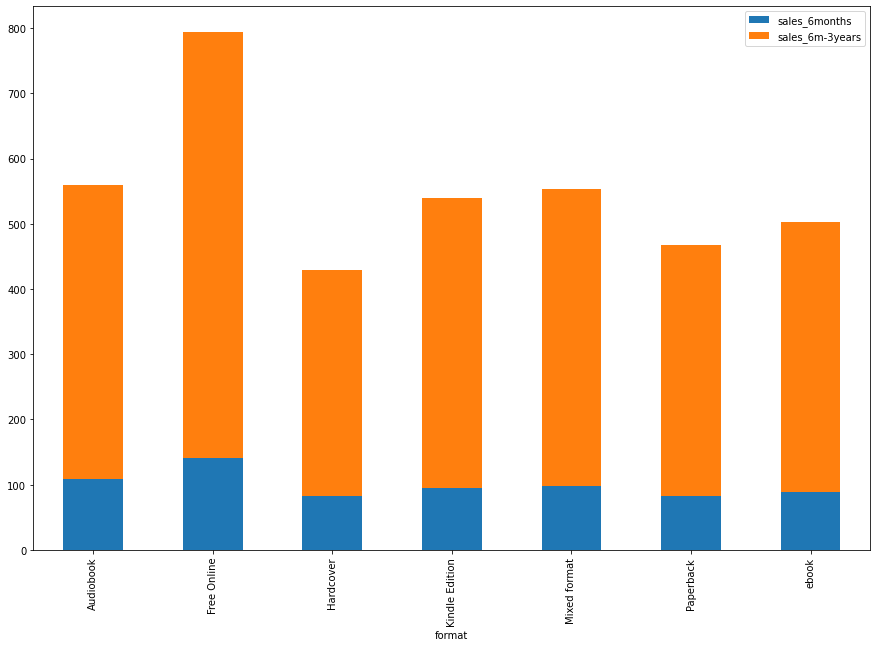

In [515]:
df[['format','sales_6months','sales_6m-3years']].groupby(['format']).mean().plot.bar(stacked=True,figsize=(15,10))

<AxesSubplot:xlabel='publication_month'>

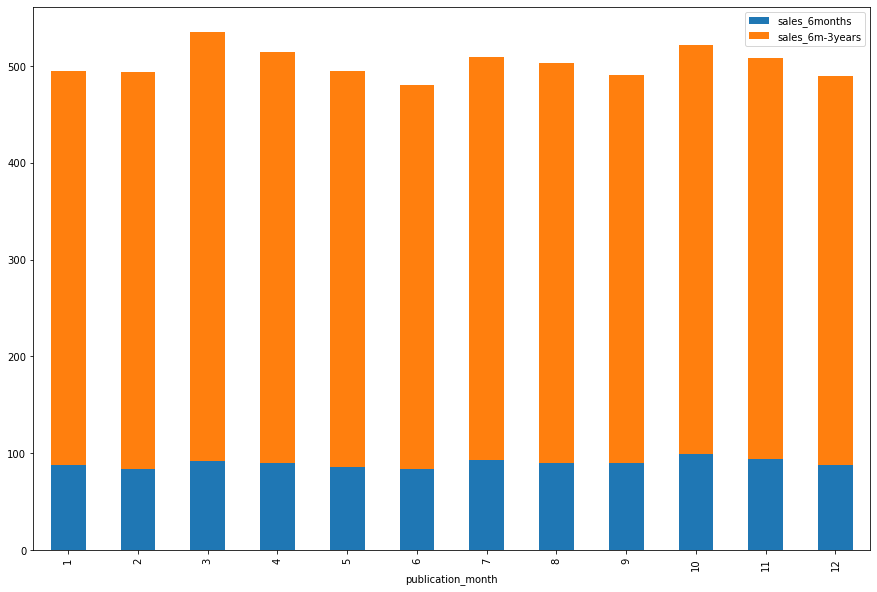

In [516]:
df[['publication_month','sales_6months','sales_6m-3years']].groupby(['publication_month']).mean().plot.bar(stacked=True,figsize=(15,10))

<AxesSubplot:xlabel='publication_day'>

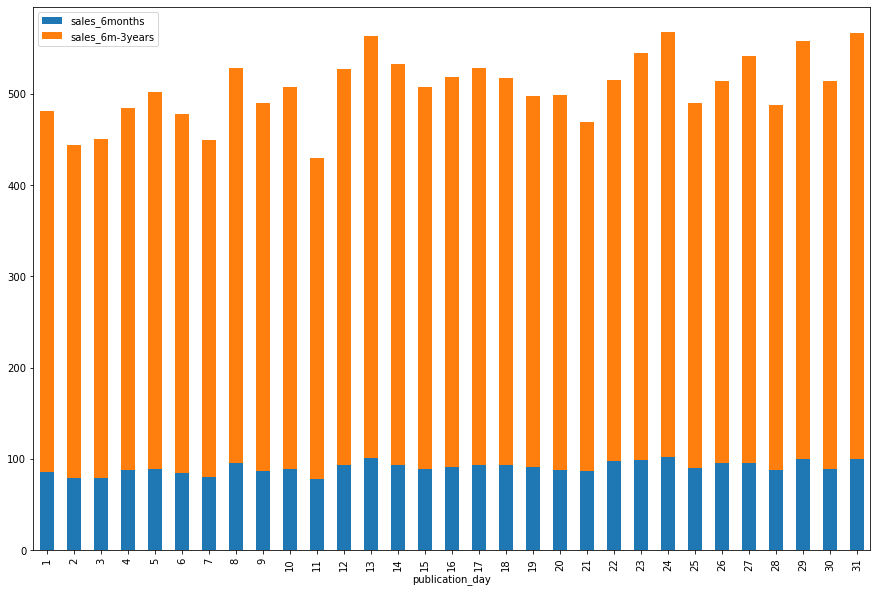

In [517]:
df[['publication_day','sales_6months','sales_6m-3years']].groupby(['publication_day']).mean().plot.bar(stacked=True,figsize=(15,10))

<AxesSubplot:xlabel='publication_year'>

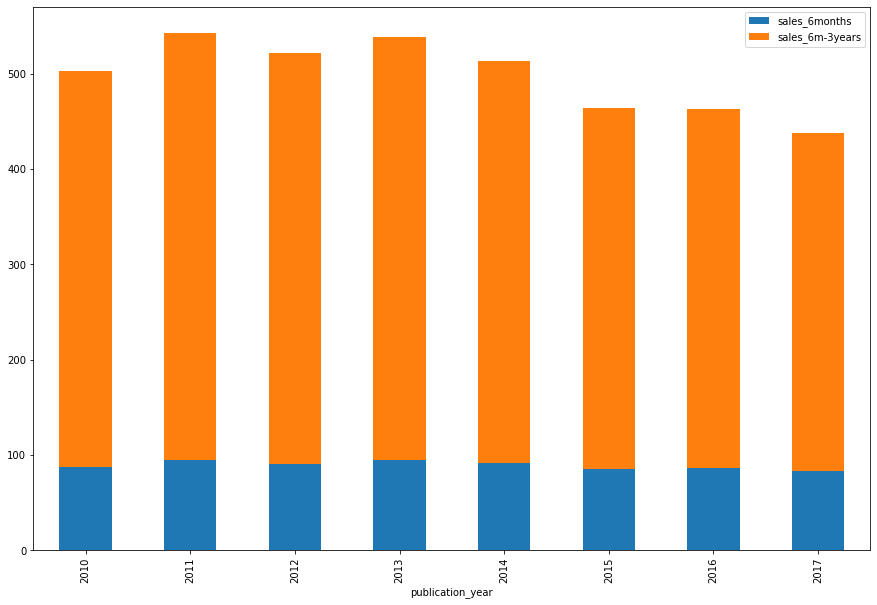

In [518]:
df[['publication_year','sales_6months','sales_6m-3years']].groupby(['publication_year']).mean().plot.bar(stacked=True,figsize=(15,10))

In [519]:
df['title_words']=df.title_without_series.str.lower().apply(word_tokenize)
df['description_words']=df.description.astype(str).str.lower().apply(word_tokenize)
df['count_title']=df.title_words.apply(len)
df['count_description']=df.description_words.apply(lambda x: len(x) if x!=['nan'] else 0)
df.head()

,max_genre_x,max_genre_y,book_id,sales_6months,sales_6m-3years,ratio_6months,ratio_3years,total,largest_ratio,isbn,...,count_title,count_description,title_analysis,description_analysis,scores_title,compound_title,comp_score_title,scores_description,compound_description,comp_score_description
0,romance,romance,24614930,335,1622,55.833333,54.066667,1957,short-term,1921901993,...,2,191,fall,long remember teagan bliss want manage family ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,"{'neg': 0.131, 'neu': 0.667, 'pos': 0.202, 'co...",0.8225,pos
7241,young-adult,young-adult,25414982,137,819,22.833333,27.300000,956,long-term,1634760123,...,12,130,order survivor 's club 1,corinna `` corey '' nguyen 's life seem perfec...,"{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'comp...",0.3612,pos,"{'neg': 0.311, 'neu': 0.485, 'pos': 0.204, 'co...",-0.7964,neg
7242,romance,romance,32336119,48,230,8.000000,7.666667,278,short-term,037378967X,...,9,194,worth wait guthrie brother 2,ready ... love find way single dad hogan guthr...,"{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'comp...",0.2263,pos,"{'neg': 0.028, 'neu': 0.675, 'pos': 0.297, 'co...",0.9893,pos
7243,romance,romance,18711348,18,31,3.000000,1.033333,49,short-term,NaN,...,15,134,duke wicked scandalous gentleman st. james 1,england 's eligible bachelor scandalous reputa...,"{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compou...",-0.7783,neg,"{'neg': 0.086, 'neu': 0.555, 'pos': 0.359, 'co...",0.9808,pos
7244,"fantasy, paranormal","fantasy, paranormal",10806008,0,26,0.000000,0.866667,26,long-term,1419700251,...,13,127,peter nimble fantastic eye peter nimble 1,peter nimble fantastic eyesis utterly beguilin...,"{'neg': 0.0, 'neu': 0.581, 'pos': 0.419, 'comp...",0.5574,pos,"{'neg': 0.173, 'neu': 0.622, 'pos': 0.205, 'co...",0.4215,pos


<AxesSubplot:xlabel='count_title'>

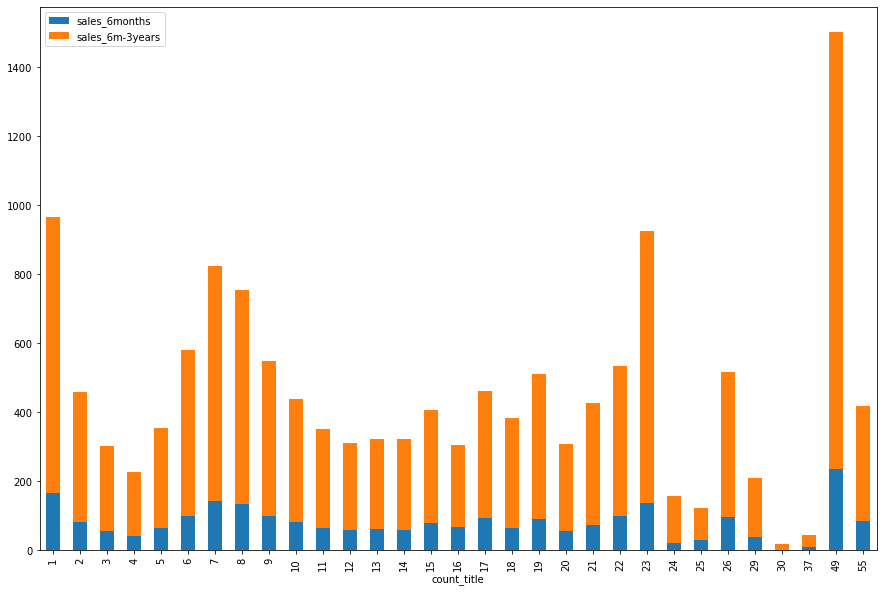

In [699]:
df[['count_title','sales_6months','sales_6m-3years']].groupby(['count_title']).mean().plot.bar(stacked=True,figsize=(15,10))

(-10.0, 800.0)

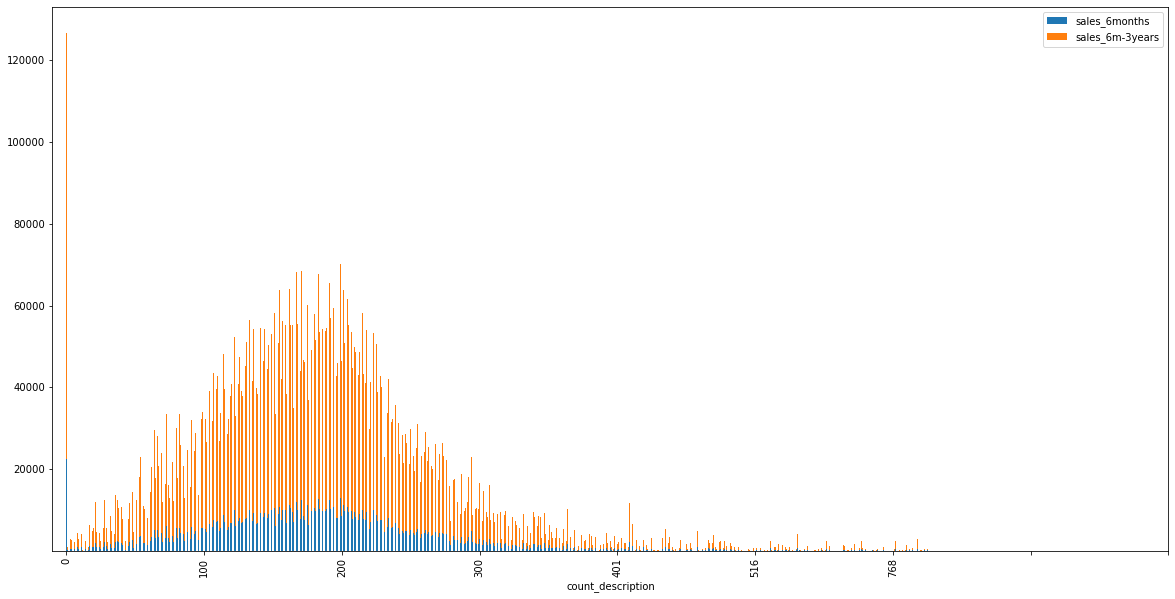

In [522]:
fig, ax = plt.subplots()
df[['count_description','sales_6months','sales_6m-3years']].groupby(['count_description']).sum().plot.bar(ax=ax,stacked=True,figsize=(20,10))
loc = matplotlib.ticker.MultipleLocator(100)
ax.xaxis.set_major_locator(loc)
plt.xlim(-10,800)

(-10.0, 800.0)

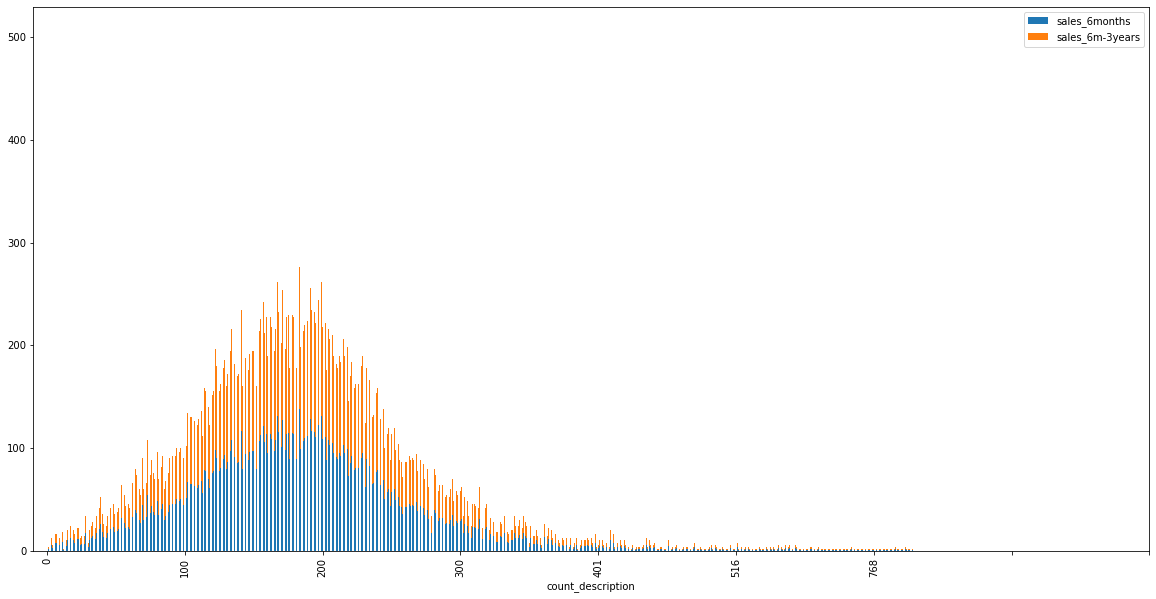

In [523]:
fig, ax = plt.subplots()
df[['count_description','sales_6months','sales_6m-3years']].groupby(['count_description']).count().plot.bar(ax=ax,stacked=True,figsize=(20,10))
loc = matplotlib.ticker.MultipleLocator(100)
ax.xaxis.set_major_locator(loc)
plt.xlim(-10,800)

In [524]:
stop_words=list(stopwords.words("english"))+['(',')',',',':','#','.','/','!','?','*',';','"']

def filter_stop_words(list_of_words):
    filtered_words=[]
    for w in list_of_words:
        if w not in stop_words:
            filtered_words.append(w)
    return filtered_words

df['title_analysis']=df.title_words.apply(filter_stop_words)
df['description_analysis']=df.description_words.apply(filter_stop_words)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,"N": wordnet.NOUN,"V": wordnet.VERB,"R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lem = WordNetLemmatizer()

def lemmatize_words(list_of_words):
    lemme_words=[]
    for w in list_of_words:
        lemme_words.append(lem.lemmatize(w,get_wordnet_pos(w)))
    return ' '.join(lemme_words)

df['title_analysis']=df.title_analysis.apply(lemmatize_words)
df['description_analysis']=df.description_analysis.apply(lemmatize_words)



In [525]:
sid = SentimentIntensityAnalyzer()

df['scores_title'] = df['title_analysis'].apply(lambda x: sid.polarity_scores(x))
df['compound_title']  = df['scores_title'].apply(lambda s : s['compound'])
df['comp_score_title'] = df['compound_title'].apply(lambda n : 'pos' if n >=0 else 'neg')

df['scores_description'] = df['description_analysis'].astype(str).apply(lambda x: sid.polarity_scores(x))
df['compound_description']  = df['scores_description'].apply(lambda s : s['compound'])
df['comp_score_description'] = df['compound_description'].apply(lambda n : 'pos' if n >=0 else 'neg')


,max_genre_x,max_genre_y,book_id,sales_6months,sales_6m-3years,ratio_6months,ratio_3years,total,largest_ratio,isbn,...,count_title,count_description,title_analysis,description_analysis,scores_title,compound_title,comp_score_title,scores_description,compound_description,comp_score_description
0,romance,romance,24614930,335,1622,55.833333,54.066667,1957,short-term,1921901993,...,2,191,fall,long remember teagan bliss want manage family ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,"{'neg': 0.131, 'neu': 0.667, 'pos': 0.202, 'co...",0.8225,pos
7241,young-adult,young-adult,25414982,137,819,22.833333,27.300000,956,long-term,1634760123,...,12,130,order survivor 's club 1,corinna `` corey '' nguyen 's life seem perfec...,"{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'comp...",0.3612,pos,"{'neg': 0.311, 'neu': 0.485, 'pos': 0.204, 'co...",-0.7964,neg
7242,romance,romance,32336119,48,230,8.000000,7.666667,278,short-term,037378967X,...,9,194,worth wait guthrie brother 2,ready ... love find way single dad hogan guthr...,"{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'comp...",0.2263,pos,"{'neg': 0.028, 'neu': 0.675, 'pos': 0.297, 'co...",0.9893,pos
7243,romance,romance,18711348,18,31,3.000000,1.033333,49,short-term,NaN,...,15,134,duke wicked scandalous gentleman st. james 1,england 's eligible bachelor scandalous reputa...,"{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compou...",-0.7783,neg,"{'neg': 0.086, 'neu': 0.555, 'pos': 0.359, 'co...",0.9808,pos
7244,"fantasy, paranormal","fantasy, paranormal",10806008,0,26,0.000000,0.866667,26,long-term,1419700251,...,13,127,peter nimble fantastic eye peter nimble 1,peter nimble fantastic eyesis utterly beguilin...,"{'neg': 0.0, 'neu': 0.581, 'pos': 0.419, 'comp...",0.5574,pos,"{'neg': 0.173, 'neu': 0.622, 'pos': 0.205, 'co...",0.4215,pos


In [532]:
# get colors most present in covers
from colorthief import ColorThief
import colorname

colors=[]
for i in df.image_url:
    file_name=i.split('/')[-1]
    try:
        urllib.request.urlretrieve(i, file_name)
        img = Image.open(file_name)
        color_thief = ColorThief(file_name)
        #display(img) #to display image if wanted
        # build a color palette
        palette = color_thief.get_palette(color_count=2)
        color=[]
        for c in palette:
            color.append(colorname.get_color_name(c[0],c[1],c[2]))
        colors.append(color)
    except :
        colors.append('')

df['covers_colors']=colors
df['covers_colors']=[set(i) for i in df['covers_colors']]

/usr/local/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [758]:
df[['comp_score_description','sales_6months','sales_6m-3years']].groupby(['comp_score_description']).aggregate(['count','sum','mean'])

sales_6months                     sales_6m-3years  \
                               count      sum       mean           count   
comp_score_description                                                     
neg                             8057   716042  88.872037            8057   
pos                            11702  1061246  90.689284           11702   

                                             
                            sum        mean  
comp_score_description                       
neg                     3284871  407.703984  
pos                     4877863  416.840113

<AxesSubplot:xlabel='comp_score_title'>

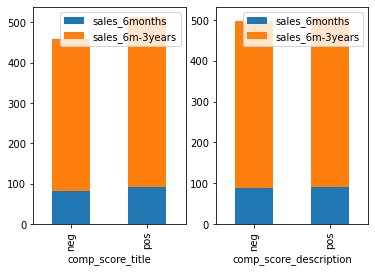

In [759]:
fig, ax = plt.subplots(nrows=1, ncols=2)
df[['comp_score_description','sales_6months','sales_6m-3years']].groupby(['comp_score_description']).mean().plot.bar(ax=ax[1],stacked=True)
df[['comp_score_title','sales_6months','sales_6m-3years']].groupby(['comp_score_title']).mean().plot.bar(ax=ax[0],stacked=True)

In [531]:
#text always seems to be accross horizontally the cover, but not always at the same level (high, middle or low part of the cover)
positions=[]
for i in df.image_url:
    file_name=i.split('/')[-1]
    try:
        urllib.request.urlretrieve(i, file_name)
        img = Image.open(file_name)
        #display(img) #to display image if wanted
        box_text= pytesseract.image_to_boxes(img,config='--psm 11')
        if box_text!='':
            l=[i.split(' ')[1:5] for i in box_text.split('\n') if i!='']
            middles=[(int(i[1])+int(i[3]))/2 for i in l]
            width, height = img.size
            pos=[]
            for k in middles:
                if k<=height/3:
                    pos.append('lower')
                elif k<= 2*height/3:
                    pos.append('middle')
                else:
                    pos.append('higher')
            pos=set(pos)  
            
        else:
            pos=''
        positions.append(pos)
    except:
        positions.append('')
df['text_positions']=positions   
df.text_positions=[list(i) for i in df.text_positions] 

/usr/local/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
# get colors most present in covers
from colorthief import ColorThief
import colorname

colors=[]
for i in df.image_url:
    file_name=i.split('/')[-1]
    try:
        urllib.request.urlretrieve(i, file_name)
        img = Image.open(file_name)
        color_thief = ColorThief(file_name)
        #display(img) #to display image if wanted
        # build a color palette
        palette = color_thief.get_palette(color_count=2)
        color=[]
        for c in palette:
            color.append(colorname.get_color_name(c[0],c[1],c[2]))
        colors.append(color)
    except :
        colors.append('')

df['covers_colors']=colors
df['covers_colors']=[set(i) for i in df['covers_colors']]

In [897]:
# define dataset
X_cat = df[['format','publication_month','count_title','count_description','comp_score_title','comp_score_description','covers_colors','text_positions']]

X_cat['lower']=[1 if 'lower' in i else 0 for i in df['text_positions']]
X_cat['middle']=[1 if 'middle' in i else 0 for i in df['text_positions']]
X_cat['higher']=[1 if 'higher' in i else 0 for i in df['text_positions']]

for c in set([val for sublist in df.covers_colors for val in sublist]):
	X_cat[c]=[1 if c in i else 0 for i in df['covers_colors']]
X_cat=X_cat.drop(['text_positions','covers_colors'],axis=1) 

X=pd.get_dummies(data=X_cat, drop_first=True, columns=['publication_month','format','comp_score_description','comp_score_title'])
X=X.drop(['format_Free Online','format_Mixed format'],axis=1)
y = df['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

results = sm.OLS(y_train, X_train).fit()
print(results.summary())

p_train=results.predict(X_train)
p_test=results.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))

print(RMSE_train)
print(RMSE_test)

                                 OLS Regression Results                                
Dep. Variable:                  total   R-squared (uncentered):                   0.352
Model:                            OLS   Adj. R-squared (uncentered):              0.350
Method:                 Least Squares   F-statistic:                              276.2
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                        0.00
Time:                        01:11:20   Log-Likelihood:                     -1.2558e+05
No. Observations:               15807   AIC:                                  2.512e+05
Df Residuals:                   15776   BIC:                                  2.515e+05
Df Model:                          31                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

<ipython-input-897-409a3434b607>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat['lower']=[1 if 'lower' in i else 0 for i in df['text_positions']]
<ipython-input-897-409a3434b607>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat['middle']=[1 if 'middle' in i else 0 for i in df['text_positions']]
<ipython-input-897-409a3434b607>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

                   publication_month  count_title  count_description  \
publication_month           1.000000     0.012416          -0.004469   
count_title                 0.012416     1.000000           0.062827   
count_description          -0.004469     0.062827           1.000000   
lower                      -0.013291     0.003979           0.011573   
middle                     -0.002632    -0.007913           0.000164   
higher                     -0.014957    -0.005061          -0.002848   
white                      -0.008033    -0.034243          -0.061562   
black                      -0.004960    -0.028828          -0.012143   
green                      -0.003179    -0.011947           0.006090   
yellow                     -0.002833    -0.034800          -0.027325   
red                         0.005185     0.021861           0.035516   
magenta                     0.001018     0.032562           0.013743   
gray                        0.002665     0.018402           0.01

<AxesSubplot:>

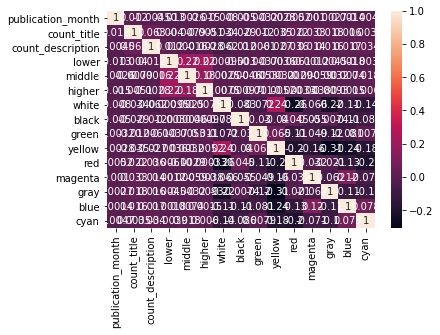

In [898]:
import seaborn as sn
corr_matrix = X_cat.corr()
print(corr_matrix)
sn.heatmap(corr_matrix, annot=True)

In [902]:
# define dataset
X_cat = df[['format','publication_month','count_title','count_description','comp_score_title','comp_score_description','covers_colors']]#,'text_positions'

# X_cat['lower']=[1 if 'lower' in i else 0 for i in df['text_positions']]
# X_cat['middle']=[1 if 'middle' in i else 0 for i in df['text_positions']]
# X_cat['higher']=[1 if 'higher' in i else 0 for i in df['text_positions']]

for c in set([val for sublist in df.covers_colors for val in sublist]):
	X_cat[c]=[1 if c in i else 0 for i in df['covers_colors']]
X_cat=X_cat.drop(['covers_colors'],axis=1) #'text_positions',

X=pd.get_dummies(data=X_cat, drop_first=True, columns=['publication_month','format','comp_score_description','comp_score_title'])
X=X.drop(['format_Free Online','format_Mixed format'],axis=1)
y = df['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

results = sm.OLS(y_train, X_train).fit()
print(results.summary())


p_train=results.predict(X_train)
p_test=results.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))

print(RMSE_train)
print(RMSE_test)

<ipython-input-902-49c4d8ccbf64>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[c]=[1 if c in i else 0 for i in df['covers_colors']]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.352
Model:                            OLS   Adj. R-squared (uncentered):              0.350
Method:                 Least Squares   F-statistic:                              305.5
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                        0.00
Time:                        01:13:46   Log-Likelihood:                     -1.2558e+05
No. Observations:               15807   AIC:                                  2.512e+05
Df Residuals:                   15779   BIC:                                  2.514e+05
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
count_title                   -5.4102      1.298     -4.167      0.000      -7.955      -2.865
count_description              0.1260      0.056      2.236      0.025       0.016       0.236
white                        128.7720     21.659      5.946      0.000      86.319     171.225
black                         74.8961     18.396      4.071      0.000      38.839     110.954
green                         60.2342     22.958      2.624      0.009      15.235     105.234
yellow                        33.6404     12.731      2.642      0.008       8.686      58.594
red                           59.4166     12.173      4.881      0.000      35.555      83.278
magenta                       47.7553     21.730      2.198      0.028       5.163      90.348
gray                         112.3783     12.290      9.144      0.000      88.288     136.468
blue                          49.9317     15.799      3.160      0.002      18.963      80.900
cyan                          60.4642     13.551      4.462      0.000      33.903      87.026
publication_month_2          181.8499     25.787      7.052      0.000     131.305     232.394
publication_month_3          220.1097     25.394      8.668      0.000     170.334     269.886
publication_month_4          191.6129     25.369      7.553      0.000     141.887     241.339
publication_month_5          183.3008     25.026      7.324      0.000     134.248     232.354
publication_month_6          166.0068     24.746      6.708      0.000     117.502     214.511
publication_month_7          183.8701     25.894      7.101      0.000     133.115     234.625
publication_month_8          182.3896     25.105      7.265      0.000     133.180     231.599
publication_month_9          157.5523     24.731      6.371      0.000     109.076     206.028
publication_month_10         207.5649     24.433      8.495      0.000     159.673     255.456
publication_month_11         195.9433     25.539      7.672      0.000     145.884     246.003
publication_month_12         158.3624     27.181      5.826      0.000     105.084     211.640
format_Hardcover               8.5954     23.911      0.359      0.719     -38.274      55.465
format_Kindle Edition        123.2671     19.523      6.314      0.000      85.000     161.534
format_Paperback              53.7761     20.304      2.649      0.008      13.978      93.574
format_ebook                  88.7227     19.546      4.539      0.000      50.410     127.035
comp_score_description_pos    25.1477     11.130      2.259      0.024       3.331      46.964
comp_score_title_pos         122.3133     13.603      8.992      0.000      95.649     148.977
=======================================

In [711]:
#for visual anaysis on tableau
df.loc[df.series.str.len() > 2,'has_serie']=1
df[['max_genre_x','has_serie', 'publisher', 'num_pages','sales_6months','sales_6m-3years','publication_day', 'publication_month','publication_year','format','count_title', 'count_description','title_analysis', 'description_analysis', 'compound_title', 'comp_score_title', 'compound_description', 'comp_score_description', 'covers_colors','text_positions']].to_csv('df_tableau.csv')

## Post-release

Will only keep reviews in the first 3 months after publication

In [776]:
col=['max_genre_x', 'book_id', 'sales_6months',
       'sales_6m-3years', 'total', 'text_reviews_count',
       'average_rating', 'format', 'publisher', 'num_pages',
       'ratings_count', 'title_without_series', 'publication_date', 
       'compound_title', 'comp_score_title', 
       'compound_description', 'comp_score_description','has_serie']
reviews.book_id=reviews.book_id.astype(str)
interactions.book_id=interactions.book_id.astype(str)
reviews_3m.date_added=pd.to_datetime(reviews_3m.date_added,utc=True)
reviews_3m.publication_date=pd.to_datetime(reviews_3m.publication_date,utc=True)
interactions.date_added=pd.to_datetime(interactions.date_added,utc=True)
reviews_3m=reviews.merge(df[col], on='book_id')
interactions_3m=interactions.merge(df[col], on='book_id')
interactions_3m.publication_date=pd.to_datetime(interactions_3m.publication_date,utc=True)
reviews_3m=reviews_3m.loc[(reviews_3m.date_added>=reviews_3m.publication_date)&(reviews_3m.date_added<=reviews_3m.publication_date+pd.DateOffset(months=3))]
interactions_3m=interactions_3m.loc[(interactions_3m.date_added>=interactions_3m.publication_date)&(interactions_3m.date_added<=interactions_3m.publication_date+pd.DateOffset(months=3))]
reviews.dtypes

user_id         object
book_id         object
review_id       object
rating           int64
review_text     object
date_added      object
date_updated    object
read_at         object
started_at      object
n_votes          int64
n_comments       int64
dtype: object

In [824]:
reviews_3m['text_analysis']=reviews_3m.review_text.astype(str).str.lower().replace('\n',"")

import emoji
# Loading dictionary of smilies
def load_dict_smileys():
 
 return {
 ":-)": "smiley",
 ":)": "smiley",
 ":D": "smiley",
 "xD": "smiley",
 ":’)": "smiley",
 ":’D": "smiley",
 ":3": "smiley",
 ":]": "smiley",
 ":^)": "smiley",
 ":))": "smiley",
 "8-)": "cool",
 "8)": "cool",
 "8-D": "cool",
 "B)": "cool",
 "BD": "cool",
 ":-}": "smiley",
 ":>": "smiley",
 ":}": "smiley",
 ":o)": "smiley",
 ":c)": "smiley",
 "=)": "smiley",
 "=D": "smiley",
 "=]": "smiley",
 ":-D": "smiley",
 "XD": "smiley",
 ":o": "surprised",
 ":O": "surprised",
 "=o": "surprised",
 "=O": "surprised",
 ":0": "surprised",
 ":(": "sad",
 ":C": "sad",
 ":c": "sad",
 "=(": "sad",
 "=c": "sad",
 "=C": "sad",
 ":-(": "sad",
 ":-c": "sad",
 ":-C": "sad",
 ":-<": "sad",
 ":<": "sad",
 ":[": "sad",
 ":{": "sad",
 ":’(": "crying",
 ":P": "playful",
 ":p": "playful",
 "xP": "playful",
 "XP": "playful",
 "=P": "playful",
 "=p": "playful",
 "xp": "playful",
 "xb": "playful",
 "❤": "love",
 "</3": "sad",
 ":/": "worried",
 ":-/": "worried"
 }

# Removing smilies and emojis
def remove_emojis(tweet):
    smilies = load_dict_smileys()
    split_tweet = tweet.split(" ")
    for key,val in smilies.items():
        if key in tweet:
            new_tweet = tweet.replace(key, val)
            tweet = new_tweet
            tweet = emoji.demojize(tweet)
            tweet = ' '.join(tweet.split())
    return tweet


reviews_3m['text_analysis']=reviews_3m['text_analysis'].apply(remove_emojis)

reviews_3m.text_analysis=reviews_3m.text_analysis.apply(word_tokenize)
reviews_3m['count_text']=reviews_3m.text_analysis.apply(len)

stop_words=list(stopwords.words("english"))+['(',')',',',':','#','.','/','!','?','*',';','"',"'"]

def filter_stop_words(list_of_words):
    filtered_words=[]
    for w in list_of_words:
        if w not in stop_words:
            filtered_words.append(w)
    return filtered_words

reviews_3m['text_analysis']=reviews_3m['text_analysis'].apply(filter_stop_words)


def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,"N": wordnet.NOUN,"V": wordnet.VERB,"R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lem = WordNetLemmatizer()

def lemmatize_words(list_of_words):
    lemme_words=[]
    for w in list_of_words:
        lemme_words.append(lem.lemmatize(w,get_wordnet_pos(w)))
    return ' '.join(lemme_words)

reviews_3m['text_analysis']=reviews_3m['text_analysis'].apply(lemmatize_words)

fdist_text =reviews_3m['text_analysis'].apply(FreqDist)


<ipython-input-824-b675698c65ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_3m['text_analysis']=reviews_3m.review_text.astype(str).str.lower().replace('\n',"")
<ipython-input-824-b675698c65ec>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_3m['text_analysis']=reviews_3m['text_analysis'].apply(remove_emojis)
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [825]:
sid = SentimentIntensityAnalyzer()

reviews_3m['scores_text'] = reviews_3m['text_analysis'].apply(lambda x: sid.polarity_scores(x))
reviews_3m['compound_text']  = reviews_3m['scores_text'].apply(lambda s : s['compound'])
reviews_3m['comp_score_text'] = reviews_3m['compound_text'].apply(lambda n : 'pos' if n >=0 else 'neg')


<ipython-input-825-af946b8281cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_3m['scores_text'] = reviews_3m['text_analysis'].apply(lambda x: sid.polarity_scores(x))
<ipython-input-825-af946b8281cf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_3m['compound_text']  = reviews_3m['scores_text'].apply(lambda s : s['compound'])
<ipython-input-825-af946b8281cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [850]:
interactions_3m.loc[interactions_3m.rating==1,'rating_1']=1
interactions_3m.loc[interactions_3m.rating==2,'rating_2']=1
interactions_3m.loc[interactions_3m.rating==3,'rating_3']=1
interactions_3m.loc[interactions_3m.rating==4,'rating_4']=1
interactions_3m.loc[interactions_3m.rating==5,'rating_5']=1
interactions_3mg=interactions_3m[['book_id','is_read', 'rating_1','rating_2','rating_3','rating_4','rating_5']].groupby(['book_id']).agg({'is_read':'sum','rating_1':'sum','rating_2':'sum','rating_3':'sum','rating_4':'sum','rating_5':'sum'})

In [851]:
reviews_3m.loc[reviews_3m.comp_score_text=='pos','pos_review']=1
reviews_3m.loc[reviews_3m.comp_score_text=='neg','neg_review']=1
reviews_3mg=reviews_3m[['book_id', 'count_text','compound_text','pos_review','neg_review']].groupby(['book_id']).agg({'count_text':'mean','compound_text':'mean','pos_review':'sum','neg_review':'sum'})

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [855]:
ri=interactions_3mg.merge(reviews_3mg,how='left',on='book_id')
rid=df[['book_id','total']].merge(ri, on='book_id')

In [913]:
# define dataset

X=rid[['is_read', 'rating_1', 'rating_2', 'rating_3',
       'rating_4', 'rating_5', 'count_text', 'compound_text', 'pos_review',
       'neg_review']]
X=X.fillna(0)
y = rid['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

results = sm.OLS(y_train, X_train).fit()
print(results.summary())

p_train=results.predict(X_train)
p_test=results.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))

print(RMSE_train)
print(RMSE_test)

                                 OLS Regression Results                                
Dep. Variable:                  total   R-squared (uncentered):                   0.211
Model:                            OLS   Adj. R-squared (uncentered):              0.210
Method:                 Least Squares   F-statistic:                              322.5
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                        0.00
Time:                        01:49:35   Log-Likelihood:                         -97257.
No. Observations:               12103   AIC:                                  1.945e+05
Df Residuals:                   12093   BIC:                                  1.946e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

               rating_1  rating_2  rating_3  rating_4  rating_5  count_text  \
rating_1       1.000000  0.869192  0.735457  0.559992  0.457178    0.003506   
rating_2       0.869192  1.000000  0.938023  0.774935  0.584586    0.003830   
rating_3       0.735457  0.938023  1.000000  0.915607  0.716301    0.003045   
rating_4       0.559992  0.774935  0.915607  1.000000  0.875477    0.005501   
rating_5       0.457178  0.584586  0.716301  0.875477  1.000000    0.005917   
count_text     0.003506  0.003830  0.003045  0.005501  0.005917    1.000000   
compound_text  0.004541  0.013486  0.029740  0.039131  0.039856    0.429888   
pos_review     0.595174  0.759974  0.870501  0.953707  0.901837    0.028808   
neg_review     0.638057  0.805637  0.865753  0.887957  0.787683    0.013953   

               compound_text  pos_review  neg_review  
rating_1            0.004541    0.595174    0.638057  
rating_2            0.013486    0.759974    0.805637  
rating_3            0.029740    0.870501    

<AxesSubplot:>

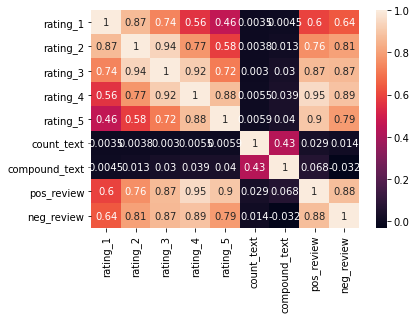

In [914]:
corr_matrix = X.drop(['is_read'],axis=1).corr()
print(corr_matrix)
sn.heatmap(corr_matrix, annot=True)

In [911]:
# define dataset

X=rid[['is_read','rating_3','rating_4', 'rating_5', 'count_text', 'compound_text','neg_review']]
X=X.fillna(0)
y = rid['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

results = sm.OLS(y_train, X_train).fit()
print(results.summary())

p_train=results.predict(X_train)
p_test=results.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))

print(RMSE_train)
print(RMSE_test)

                                 OLS Regression Results                                
Dep. Variable:                  total   R-squared (uncentered):                   0.210
Model:                            OLS   Adj. R-squared (uncentered):              0.210
Method:                 Least Squares   F-statistic:                              460.3
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                        0.00
Time:                        01:46:02   Log-Likelihood:                         -97258.
No. Observations:               12103   AIC:                                  1.945e+05
Df Residuals:                   12096   BIC:                                  1.946e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [912]:
    # define dataset

X=rid[['compound_text']]
X=X.fillna(0)
y = rid['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

results = sm.OLS(y_train, X_train).fit()
print(results.summary())

p_train=results.predict(X_train)
p_test=results.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))

print(RMSE_train)
print(RMSE_test)

                                 OLS Regression Results                                
Dep. Variable:                  total   R-squared (uncentered):                   0.194
Model:                            OLS   Adj. R-squared (uncentered):              0.194
Method:                 Least Squares   F-statistic:                              2907.
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                        0.00
Time:                        01:48:54   Log-Likelihood:                         -97385.
No. Observations:               12103   AIC:                                  1.948e+05
Df Residuals:                   12102   BIC:                                  1.948e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------